# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add EllipticOECS folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/EllipticOECS")

Wall time: 0 ns


# Overview

In the following notebook we extract elliptic objective Eulerian coherent structures (elliptic OECS) from a two-dimensional, satellite-altimetry-derived ocean-surface current product (AVISO). The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. Elliptic OECS:

    * Compute gradient of velocity field $ \mathbf{\nabla v}(\mathbf{x}. t) $ over meshgrid using an auxiliary meshgrid. 
   <br />
   
    * Compute rate of strain: 
   <br />
   
    \begin{equation} \mathbf{S}(\mathbf{x}, t) = \begin{pmatrix} S_{11} & S_{12} \\ S_{11} & S_{12} \end{pmatrix} = \dfrac{1}{2}(\mathbf{\nabla v}(\mathbf{x}, t)+\mathbf{\nabla v}(\mathbf{x}, t)^T)  \end{equation}
   <br />
   
    * Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics:
   <br />
   
    \begin{equation}
    \mathrm{A_{\mu}(\mathbf{x},t)} = S(\mathbf{x}, t) - \mu\mathbf{I}, \quad \mu \in \mathbb{R}
    \end{equation}
  
    Closed null geodesics are closed curves of the system of ODE:
    
    \begin{align*}
    \dfrac{d \mathbf{x}}{ds} &= \mathbf{e}_{\phi}(s) = \begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix} \\
    \dfrac{d \phi}{ds} &= - \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)}, 
    \end{align*} where $ R = \begin{pmatrix} 0 && -1 \\ 1 && 0\end{pmatrix} $. 
    
  $ \dfrac{d \phi}{ds} $ depends both on $ \mathbf{x} $ and on $ \phi $ and can be evaluated through interpolation by first computing $ \dfrac{\langle \mathbf{e}_{\phi}(s), (\nabla_x A(\mathbf{x}) \mathbf{e}_{\phi}(s)) \mathbf{e}_{\phi}(s) \rangle}{2 \langle \mathbf{e}_{\phi}, R^T A(\mathbf{x}) \mathbf{e}_{\phi}(s)} $ over the spatial meshgrid (X, Y) as well as over $ \phi \in [0, 2\pi] $. 
    
  It holds:
  \begin{equation}
  \dfrac{d \phi}{ds} = -\dfrac{\cos^2(\phi)[S_x^{11}(\mathbf{x})(\mathbf{x})\cos(\phi)+S_y^{11}(\mathbf{x})\sin(\phi)]+[S_x^{12}(\mathbf{x})\cos(\phi)+S_y^{11}(\mathbf{x})(\mathbf{x})\sin(\phi)]\sin(2\phi)+\sin^2(\phi)[S_x^{22}(\mathbf{x})\cos(\phi)+S_y^{22}(\mathbf{x})\sin(\phi)]}{\sin(2\phi)[S^{22}(\mathbf{x})-S^{11}(\mathbf{x})]+2\cos(2\phi)S^{12}(\mathbf{x})}
  \end{equation}
    
  The set of initial conditions is given by:
    \begin{equation}
    (\mathbf{x}_0, \phi_0)_{\mu} = \lbrace (\mathbf{x}_0(\mu, \phi = 0), 0) \in V: S^{11}(\mathbf{x})- \mu = 0 \rbrace
    \end{equation}
    
  Furthermore the system of ODE is only well defined for
    
  \begin{equation}
    \sin(2\phi)[S^{22}(\mathbf{x})-S^{11}(\mathbf{x})]+2\cos(2\phi)S^{12}(\mathbf{x}) \neq 0
  \label{eq: DOE}
  \end{equation}
  
  If the trajectory violates condition $ \ref{eq: DOE} $, then the integration is stopped. 

# Import Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

Wall time: 115 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
%%time
import numpy as np

# Number of cores for parallel computing
Ncores = 5 # int

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Periodic boundary conditions
periodic_x = False # bool 
periodic_y = False # bool
periodic_t = False # bool
periodic = [periodic_x, periodic_y, periodic_t]# list (3,)

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

# Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX)

# Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2,)

Wall time: 0 ns


# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Time
t_OECS = 0 # float

# store time in array
time = np.array([t_OECS]) # array (1,)

# longitudinal and latitudinal boundaries (in degrees)
xmin = -3 # float
xmax = 1 # float
ymin = -32 # float
ymax = -24 # float

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and np.min(time_data) <= t_OECS <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"
    
# spacing of meshgrid (in degrees)
dx = 0.01 # float
dy = 0.01 # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx,)
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny,)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Nx = X_domain.shape[0]
Ny = X_domain.shape[1]

Wall time: 1.99 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear".

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline object

Wall time: 189 ms


# Rate of strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x} $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid.

In [6]:
%%time

# Import package for parallel computing
from joblib import delayed, Parallel

# Import function to compute gradient of velocity
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .2 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])] # list (2,)

# vectorize initial conditions by arranging them to a vector of size (Nx*Ny, 2)
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

# split x0, y0 into 'Ncores' batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

def parallel_S(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)
        
    # compute gradient of velocity field
    grad_vel = gradient_velocity(t_OECS, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, delta, aux_grid) # (2,2,Nx*Ny)
    
    # compute rate of strain tensor
    S = .5*(grad_vel+grad_vel.transpose(1,0,2))

    return S

results = Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract rate of strain tensor from results of parallel computation
S = results[0]

for i in range(1,len(results)):
    
    S = np.append(S, results[i], axis = 2)
    
# reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
Y0_gridded = y0.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)
S = S.reshape((2, 2, X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)

Wall time: 4.76 s


# Compute tensorfield

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS        

# Compute gradients of elements of rate of strain tensor
S11 = S[0,0,:,:].copy() # array (Ny, Nx)
S12 = S[0,1,:,:].copy() # array (Ny, Nx)
S22 = S[1,1,:,:].copy() # array (Ny, Nx)
    
# Interpolate elements of rate of strain tensor (per default: linear)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S11, nan = 0.0), kx = 1, ky = 1) # RectangularBivariateSpline object
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S12, nan = 0.0), kx = 1, ky = 1) # RectangularBivariateSpline object
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(S22, nan = 0.0), kx = 1, ky = 1) # RectangularBivariateSpline object

# Initialize arrays
S11x = np.zeros((X_domain.shape[0], X_domain.shape[1]))*np.nan # array (Ny, Nx)
S11y = S11x.copy() # array (Ny, Nx)
S12x = S11x.copy() # array (Ny, Nx)
S12y = S11x.copy() # array (Ny, Nx)
S22x = S11x.copy() # array (Ny, Nx)
S22y = S11x.copy() # array (Ny, Nx)
     
# Define auxilary meshgrid
rho_x = aux_grid[0]/2 # float
rho_y = aux_grid[1]/2 # float
        
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)

# Interpolate $ \dot{\phi}(x, y, \phi)$ 

In [8]:
%%time
import time
# Import package for computing interpolant of phi_prime and the domain of existence
from ipynb.fs.defs.phi_prime import _phi_prime

# Interpolant phi_phrime, interpolant indicating domain of existence (= denominator of phi_prime)
interp_phi_prime, interp_DOE = _phi_prime(X_domain, Y_domain, S11, S12, S22, S11x, S11y, S12x, S12y, S22x, S22y) # RectangularGridInterpolant object, RectangularGridInterpolant object

Wall time: 1.88 s


# Elliptic OECSs

Elliptic OECSs are closed null geodesics of the one-parameter family of Lorentzian metrics $ S(\mathbf{x}, t) − \mu $. $ \mu ∈ \mathbb{R} $ denotes the tangential stretch rate along an elliptic OECS. For perfectly coherent elliptic OECS with no tangential stretching (=filamentation) it holds that $ \mu = 0 $.  

In [9]:
%%time
# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Import function to extract closed null geodesics
from ipynb.fs.defs.closed_null_geodesics import closed_null_geodesics

# Define mu range
mu_min = -0.01
mu_max = 0.01
n_mu = 3*Ncores
mu_range = np.linspace(mu_min, mu_max, n_mu)

# Threshold distance between starting and return point of trajectory
d_threshold = dx

# Compute elliptic OECS
def compute_ellipitic_OECS(mu):
    
    # Define list storing x, y coordinates of elliptic OECS
    x_elliptic, y_elliptic = [], []
    
    # Find all closed null geodesics
    closed_NG, init_mu = closed_null_geodesics(X_domain, Y_domain, mu, interp_phi_prime, d_threshold, S11, defined_domain, interp_DOE)
    
    x_elliptic, y_elliptic = [], []
    # Iterate over all geodesics
    for NG in closed_NG:
        
        if np.sum(NG[0]) is not None:
            
            x = NG[0]
            y = NG[1]
            x = np.append(x, x[0])
            y = np.append(y, y[0])
            
            x_elliptic.append(x)
            y_elliptic.append(y)
        
    return [x_elliptic, y_elliptic, init_mu]

# Compute elliptic OECS with parallel computing
Elliptic_OECS = Parallel(n_jobs=Ncores, verbose = 0)(delayed(compute_ellipitic_OECS)(i) for i in mu_range)

Wall time: 1min 34s


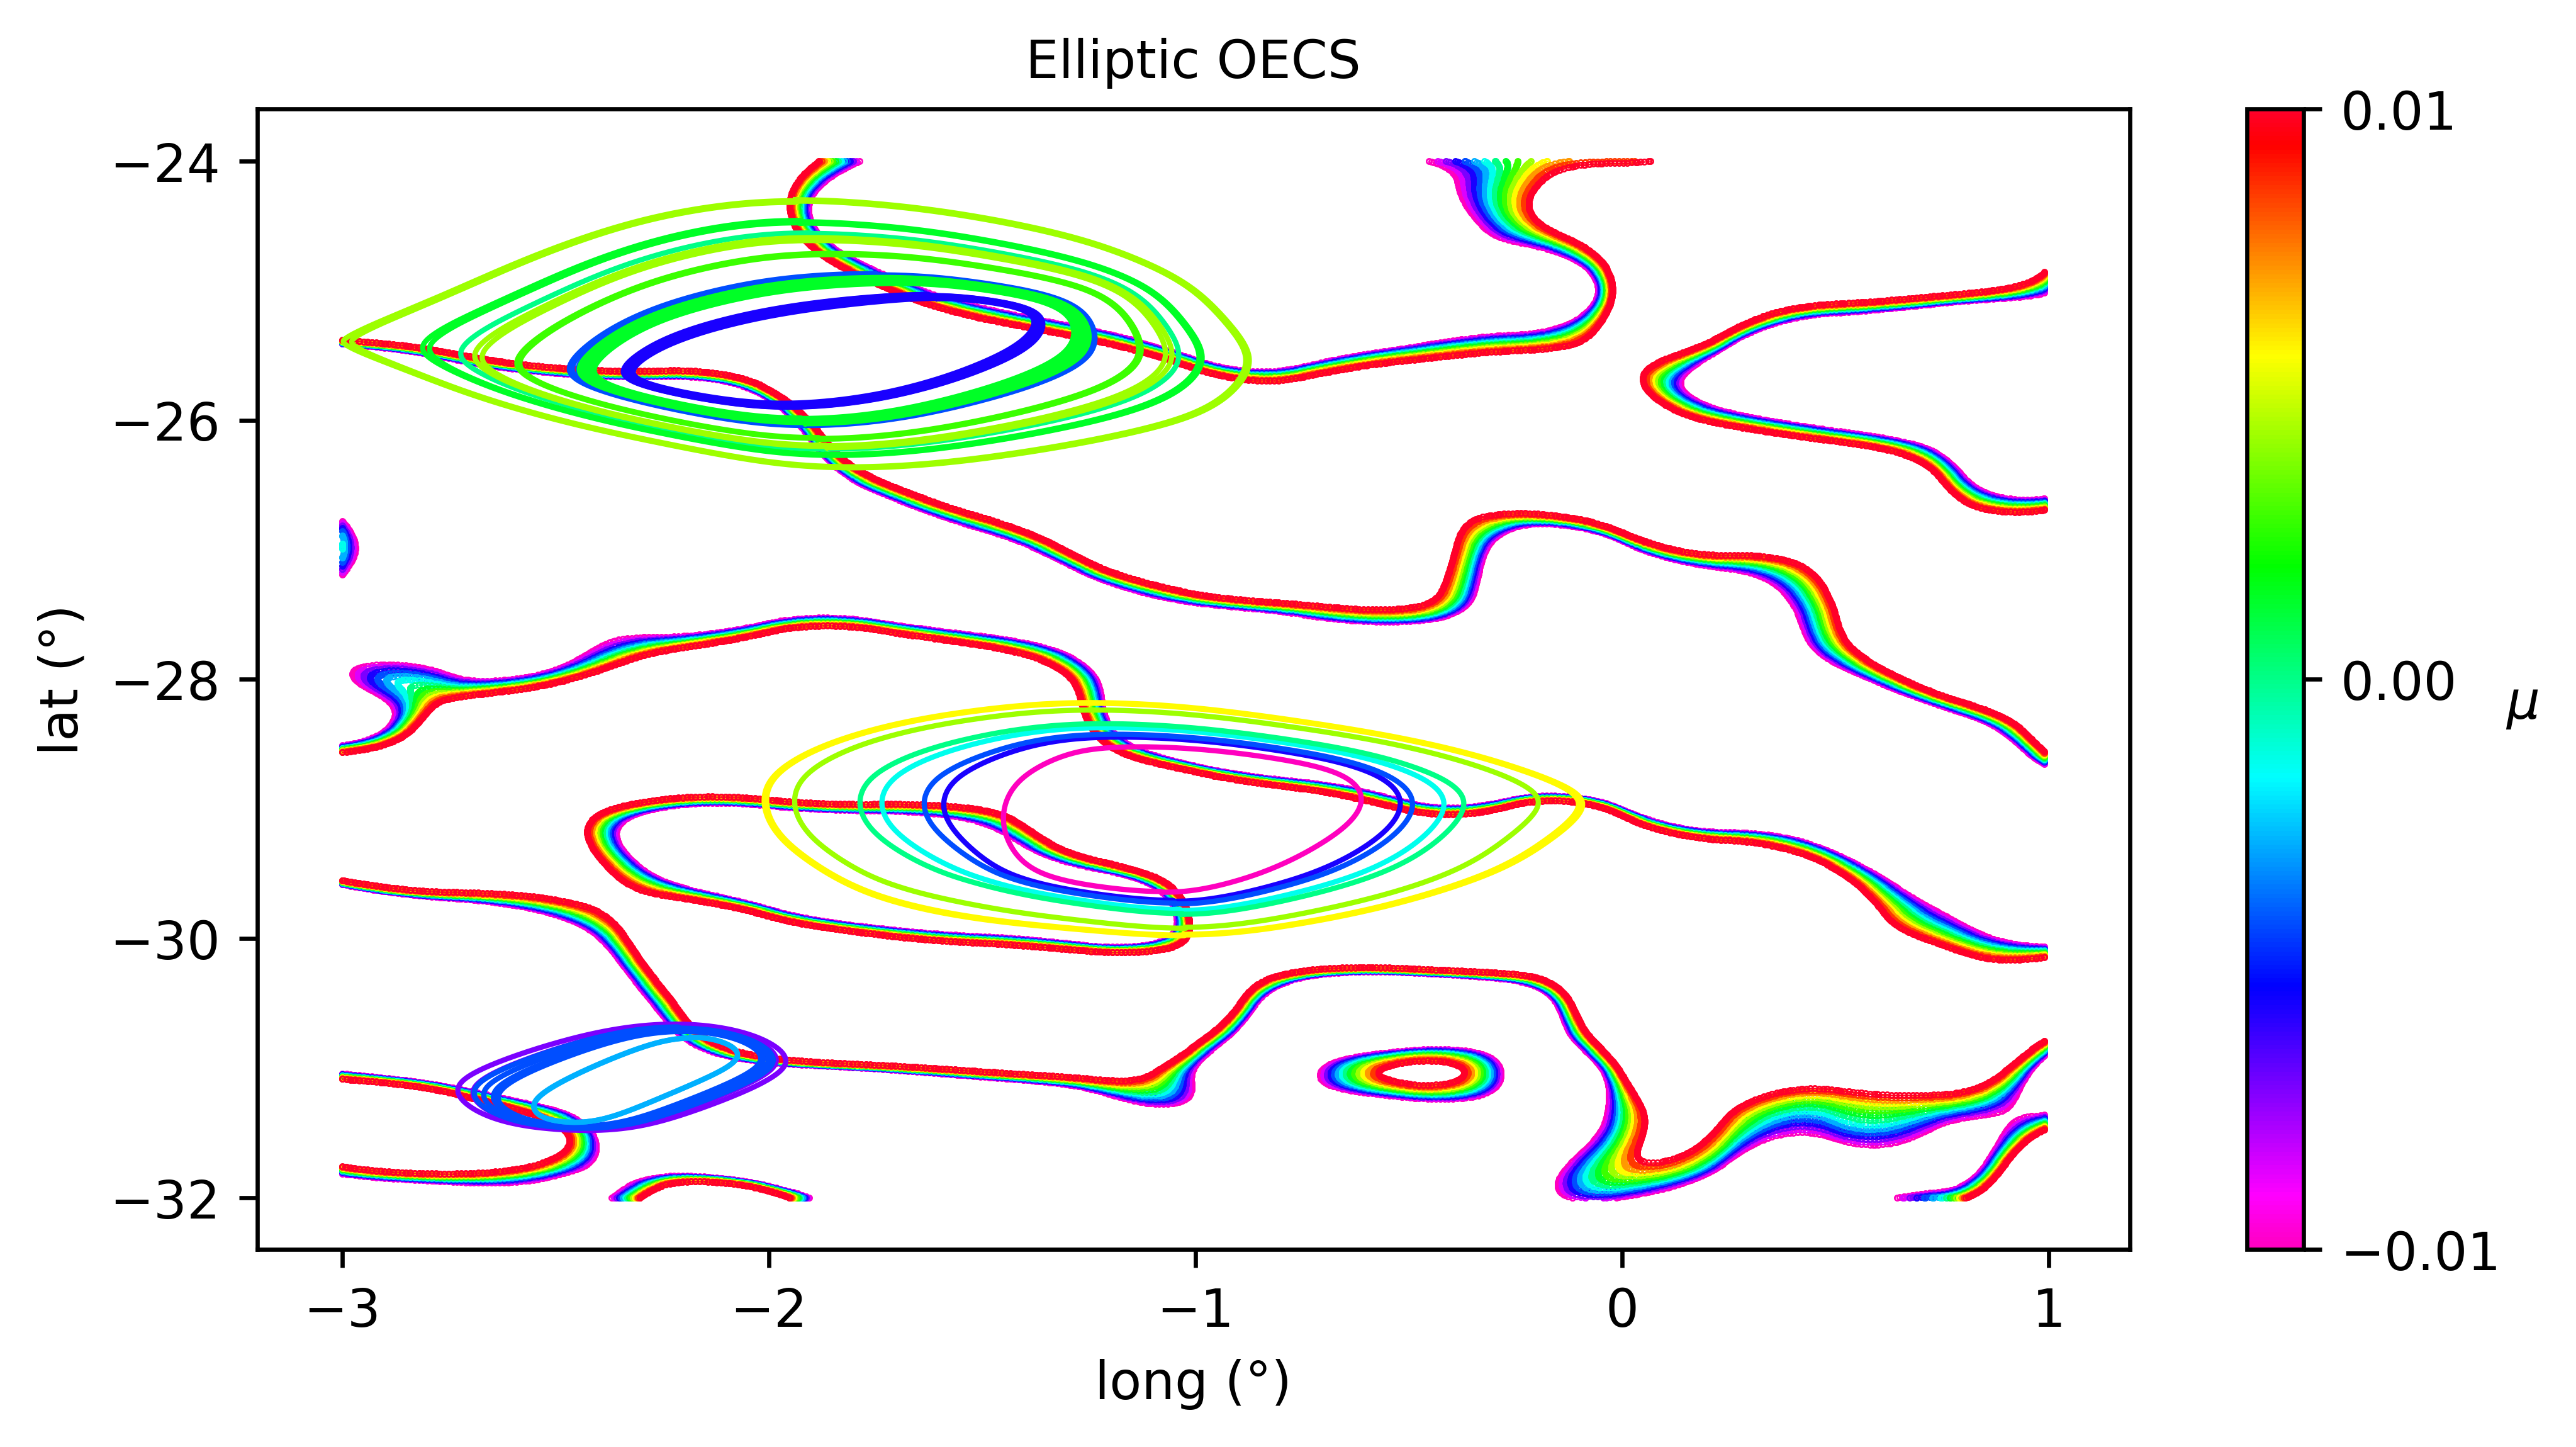

Wall time: 1.6 s


In [10]:
%%time
######################################## Plot elliptic OECS ########################################

# import plotting library
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=mu_range.min(), vmax=mu_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# Iterate over all elliptic OECS and plot
for i in range(len(Elliptic_OECS)):
    
    # Plot initial conditions
    ax.scatter(Elliptic_OECS[i][2][0], Elliptic_OECS[i][2][1], color=cmap.to_rgba(mu_range[i]), s = 0.1)
    
    # Plot elliptic OECS
    for j in range(len(Elliptic_OECS[i][0])):
        if Elliptic_OECS[i][0][j] is not None:
            ax.plot(Elliptic_OECS[i][0][j], Elliptic_OECS[i][1][j], c=cmap.to_rgba(mu_range[i]), linewidth = 1)

# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(np.min(X_domain), np.max(X_domain)+0.1, 1))
ax.set_yticks(np.arange(np.min(Y_domain), np.max(Y_domain)+0.1, 2))

# Colorbar
cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Elliptic OECS", fontsize = 10)
plt.show();

We obtain three objectively detected elliptic OECS families. The (colored) closed curves indicate elliptic OECS for different values of $ \mu $. Furthermore, the initial conditions $ \mathbf{x}_0(\mu, \phi_0 = 0) $ are also plotted as a function of $ \mu $ (see colormap).

# Advect Elliptic OECS

We now advect the computed outermost elliptic OECS over three days. The colored dashed lines denote the elliptic OECS computed at $ t_0 = 0$, whereas the colored solid lines indicate the same elliptic OECS advected after three days. Remarkably, the detected elliptic OECS show coherent behaviour even after advection and barely deform.

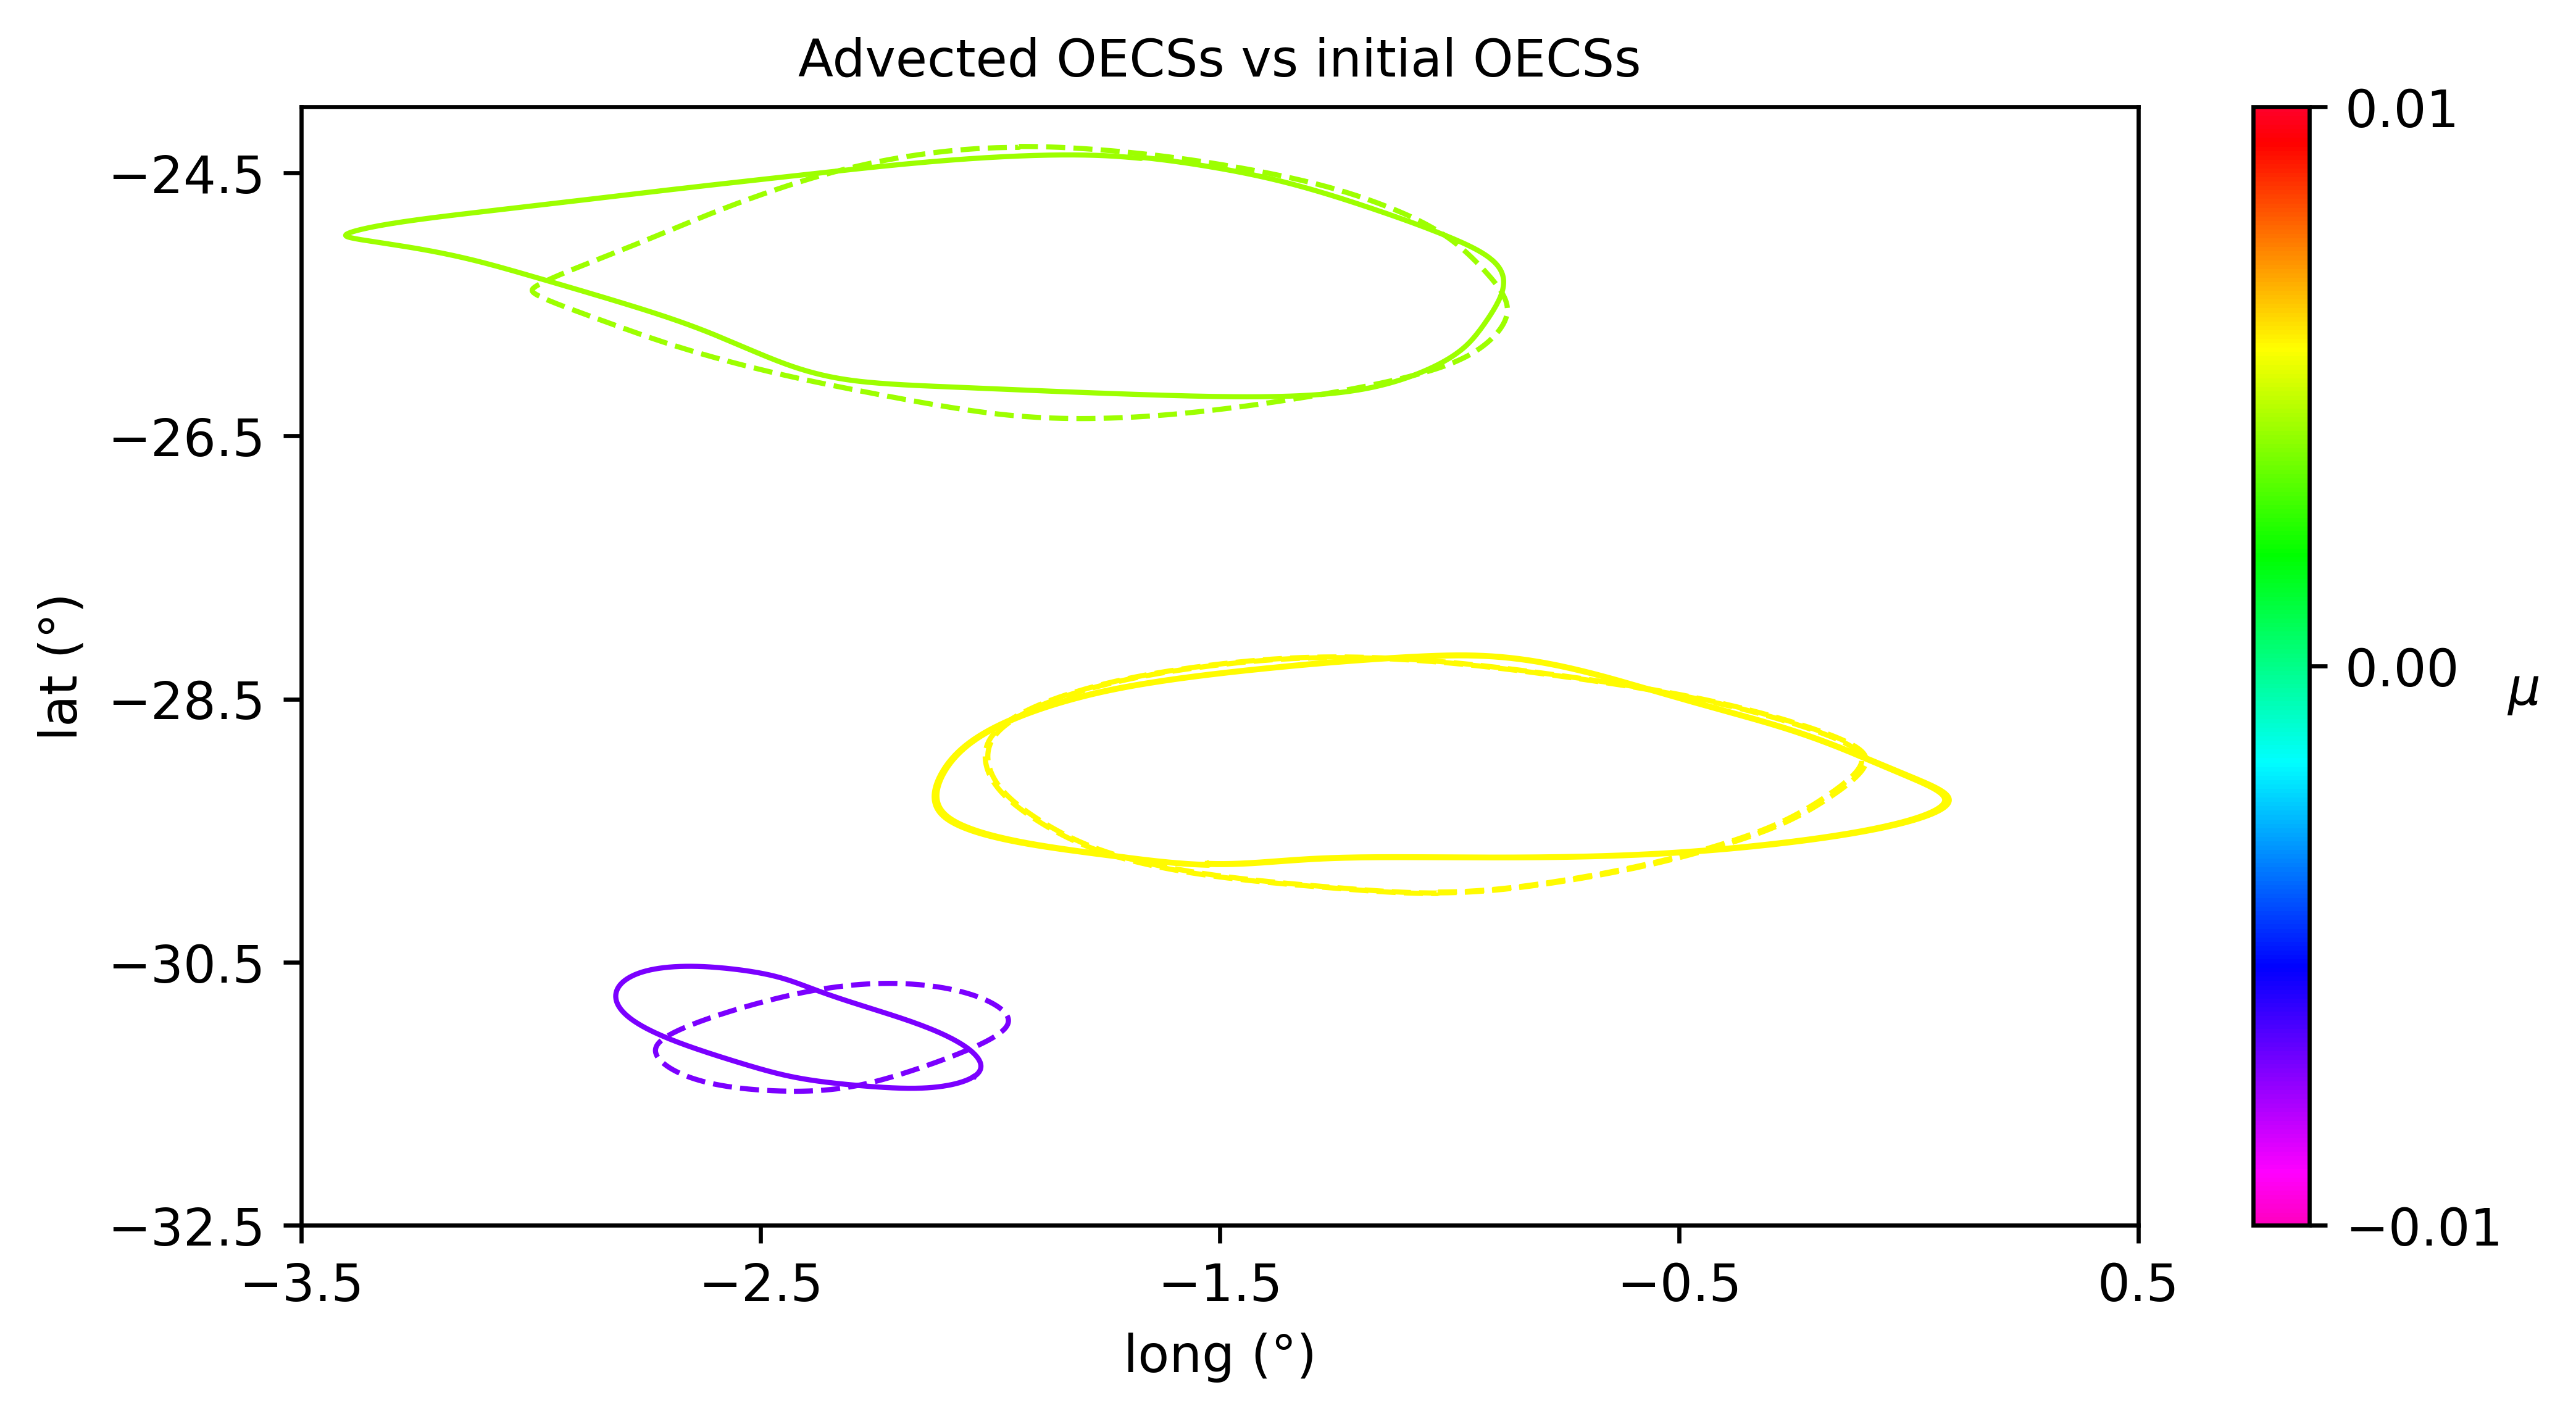

In [11]:
# Import function to compute trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# import function to extract outermost elliptic OECS for each family of elliptic OECS
from ipynb.fs.defs.find_outermost_closed_curve import find_outermost_closed_curve

# Define time-horizon over which to advect
time_advect = np.linspace(t_OECS, t_OECS+3, 100, endpoint = True)

# Define figure/axes
fig = plt.figure(figsize = (8, 4), dpi = 600)
ax = plt.axes()

# Define norm/cmap
norm = mpl.colors.Normalize(vmin=mu_range.min(), vmax=mu_range.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='gist_rainbow_r')

# find outermost elliptic OECS in each family of elliptic OECS
x_outermost_elliptic_OECS, y_outermost_elliptic_OECS, lambda_outermost_elliptic_OECS = find_outermost_closed_curve(Elliptic_OECS, mu_range)

# Iterate over outermost elliptic OECS and plot
for i in range(len(x_outermost_elliptic_OECS)):
    
    # dummy plot
    ax.scatter(np.nan, np.nan, s = 1, color=cmap.to_rgba(mu_range[i]))
    
    ax.plot(x_outermost_elliptic_OECS[i], y_outermost_elliptic_OECS[i], c=cmap.to_rgba(lambda_outermost_elliptic_OECS[i]), linewidth = 1, linestyle = "dashed")
                    
    X0 = np.array([x_outermost_elliptic_OECS[i].ravel(), y_outermost_elliptic_OECS[i].ravel()]) # array 
                    
    # Advect Elliptic LCS
    Fmap = integration_dFdt(time_advect, X0, X, Y, Interpolant_u, Interpolant_v, periodic, bool_unsteady, time_data)[0]

    # extract end-point of advection
    x_end = Fmap[:,-1] # array (2,)
                    
    x_advected = Fmap[-1,0,:] # array 
    y_advected = Fmap[-1,1,:] # array
                    
    ax.plot(x_advected, y_advected, c=cmap.to_rgba(lambda_outermost_elliptic_OECS[i]), linewidth = 1)

# Set axis limits
ax.set_xlim([-3.5, 0.5])
ax.set_ylim([-32, -24])
                
# Set axis labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(-3.5, 0.5+.1, 1))
ax.set_yticks(np.arange(-32.5, -24+.1, 2))

# Colorbar
cbar = fig.colorbar(cmap, ticks=[mu_range.min(), 0, mu_range.max()])
cbar.ax.set_ylabel(r'$ \mu $', rotation = 0, fontsize = 10)

# Title
ax.set_title("Advected OECSs vs initial OECSs", fontsize = 10)
plt.show();

# References

[1] Serra, M., & Haller, G. (2017). Efficient computation of null geodesics with applications to coherent vortex detection. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 473(2199).

[2] Notebook 5.6.3. in "Transport Barriers and Coherent Structures in Flow Data" by George Haller.